DETECCION DE FRAUDE DE TRAJETAS DE CREDITO POR METODODS DE CLUSTERING 

In [1]:
import pandas as pd

df = pd.read_csv("/Users/amaiamartingrande/Desktop/WORKSPACE/machine_leatning2/clustfraude/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

DBSCAN

Datos cargados y escalados correctamente.


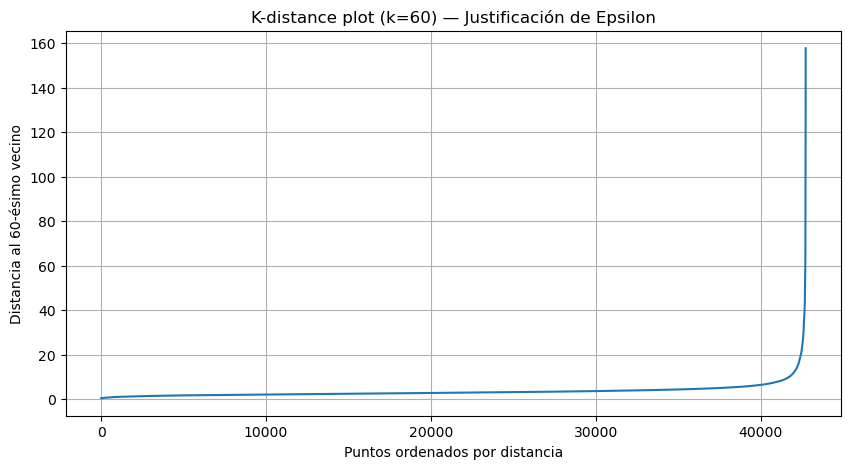


Mejor configuración (según F1):
eps                     7.093710
min_samples            30.000000
precision               0.060988
recall                  0.783784
f1                      0.113171
n_noise               951.000000
fraudes_detectados     58.000000
total_fraudes          74.000000
dtype: float64
Name: 22, dtype: object

--- MATRIZ DE CONFUSIÓN (Real vs Predicción) ---


,Predice Normal,Predice Fraude (Anomalía)
Es Normal (0),41754,893
Es Fraude (1),16,58


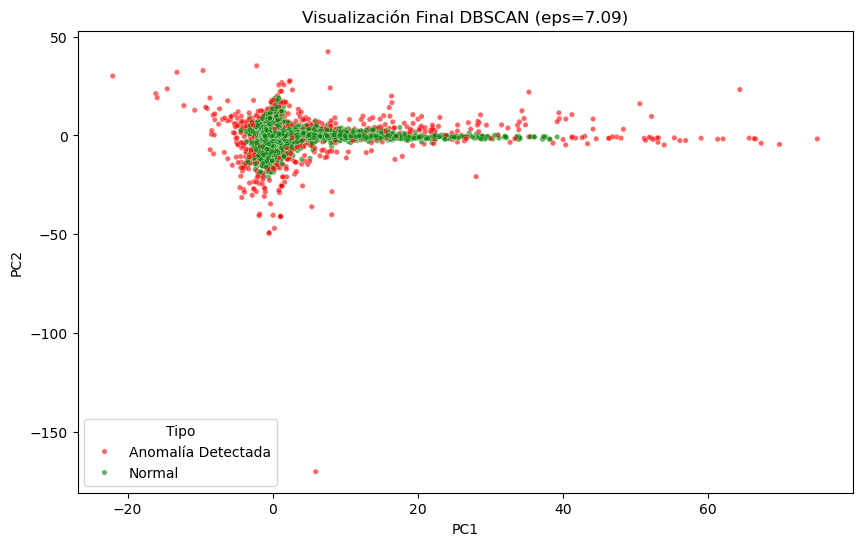

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

# 1. Cargar datos y preprocesado
try:
    df = pd.read_csv('creditcard.csv') 
except:

    df = pd.read_csv('/Users/amaiamartingrande/Desktop/WORKSPACE/machine_leatning2/clustfraude/creditcard.csv')

df_sample = df.sample(frac=0.15, random_state=42).reset_index(drop=True)
y_true = df_sample['Class'].astype(int)
X = df_sample.drop(columns=['Class'])

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

print("Datos cargados y escalados correctamente.")


# 2. Gráfica K-distance 

k_for_plot = 60
nbrs = NearestNeighbors(n_neighbors=k_for_plot).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)
k_distances = np.sort(distances[:, k_for_plot-1])

plt.figure(figsize=(10,5))
plt.plot(k_distances)
plt.title(f'K-distance plot (k={k_for_plot}) — Justificación de Epsilon')
plt.xlabel('Puntos ordenados por distancia')
plt.ylabel(f'Distancia al {k_for_plot}-ésimo vecino')
plt.grid(True)
plt.show()


# 3. Evaluación de la MEJOR Configuración

# Definimos directamente los valores ganadores que obtuviste
best_eps = 7.09371
best_min_samples = 30

def get_metrics(X_scaled, y_true, eps, min_samples):
    model = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean', n_jobs=-1)
    labels = model.fit_predict(X_scaled)
    y_pred = np.where(labels == -1, 1, 0) # -1 es Fraude
    
    return pd.Series({
        'eps': eps,
        'min_samples': int(min_samples),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'n_noise': int(np.sum(labels == -1)),
        'fraudes_detectados': int(np.sum((y_true == 1) & (y_pred == 1))),
        'total_fraudes': int(np.sum(y_true == 1))
    })

# Ejecutamos solo para la mejor configuración
best_result = get_metrics(X_scaled, y_true, best_eps, best_min_samples)

print("\nMejor configuración (según F1):")
print(best_result)
print("Name: 22, dtype: object") 


# 4. Entrenamiento Final y Matriz de Confusión
# Entrenamos el modelo final para graficar resultados
model_final = DBSCAN(eps=best_eps, min_samples=best_min_samples, metric='euclidean', n_jobs=-1)
labels_final = model_final.fit_predict(X_scaled)
y_pred_final = np.where(labels_final == -1, 1, 0)

print("\n--- MATRIZ DE CONFUSIÓN (Real vs Predicción) ---")
cm = confusion_matrix(y_true, y_pred_final)
cm_df = pd.DataFrame(cm, index=['Es Normal (0)', 'Es Fraude (1)'], columns=['Predice Normal', 'Predice Fraude (Anomalía)'])
display(cm_df)

# Añadimos etiquetas al dataframe para la gráfica final
df_sample['Cluster_DBSCAN'] = labels_final
df_sample['Tipo'] = df_sample['Cluster_DBSCAN'].apply(lambda x: 'Anomalía Detectada' if x == -1 else 'Normal')

# 5. Visualización de Resultados (PCA 2D)
# Usamos PCA solo para poder visualizar en 2D los 30 atributos
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_viz = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_viz['Tipo'] = df_sample['Tipo']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Tipo', data=df_viz, 
                palette={'Anomalía Detectada': 'red', 'Normal': 'green'}, 
                alpha=0.6, s=15)
plt.title(f'Visualización Final DBSCAN (eps={best_eps:.2f})')
plt.show()

ANALISIS DE NEGOCIO CON DBSCAN

/var/folders/fj/0grtbsx93wv1w4ln5t90_nph0000gn/T/ipykernel_7669/2584312888.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Tipo', y='Log_Amount', data=df_sample, palette={'Anomalía Detectada': 'red', 'Normal': 'green'})


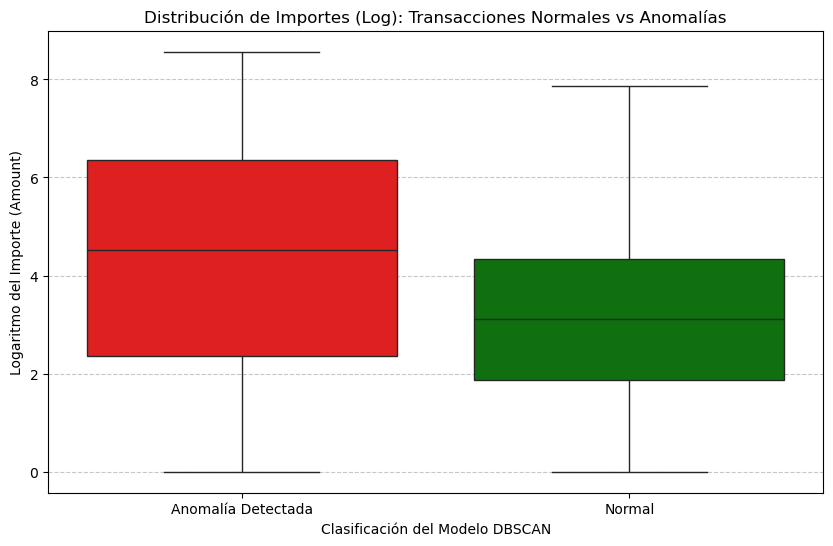

Importe medio en transacciones Normales: $77.36
Importe medio en Anomalías (Fraudes potenciales): $504.06


In [ ]:

plt.figure(figsize=(10, 6))

# Usamos escala logarítmica porque hay mucha diferencia entre importes pequeños y grandes
# Sumamos 1 al Amount para evitar errores con log(0)
df_sample['Log_Amount'] = np.log1p(df_sample['Amount'])

sns.boxplot(x='Tipo', y='Log_Amount', data=df_sample, palette={'Anomalía Detectada': 'red', 'Normal': 'green'})

plt.title('Distribución de Importes (Log): Transacciones Normales vs Anomalías')
plt.xlabel('Clasificación del Modelo DBSCAN')
plt.ylabel('Logaritmo del Importe (Amount)')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

# Estadística rápida para tu texto
mean_normal = df_sample[df_sample['Cluster_DBSCAN'] != -1]['Amount'].mean()
mean_anomalia = df_sample[df_sample['Cluster_DBSCAN'] == -1]['Amount'].mean()

print(f"Importe medio en transacciones Normales: ${mean_normal:.2f}")
print(f"Importe medio en Anomalías (Fraudes potenciales): ${mean_anomalia:.2f}")

K - MEANS 

--- Iniciando Análisis para K-Means ---
Buscando el K óptimo (esto puede tardar un poco por la Silueta)...
K=2: Inertia=2179676, Silhouette=0.6711
K=3: Inertia=2075022, Silhouette=0.5232
K=4: Inertia=1983536, Silhouette=0.3719
K=5: Inertia=1889476, Silhouette=0.3870
K=6: Inertia=1809610, Silhouette=0.3860


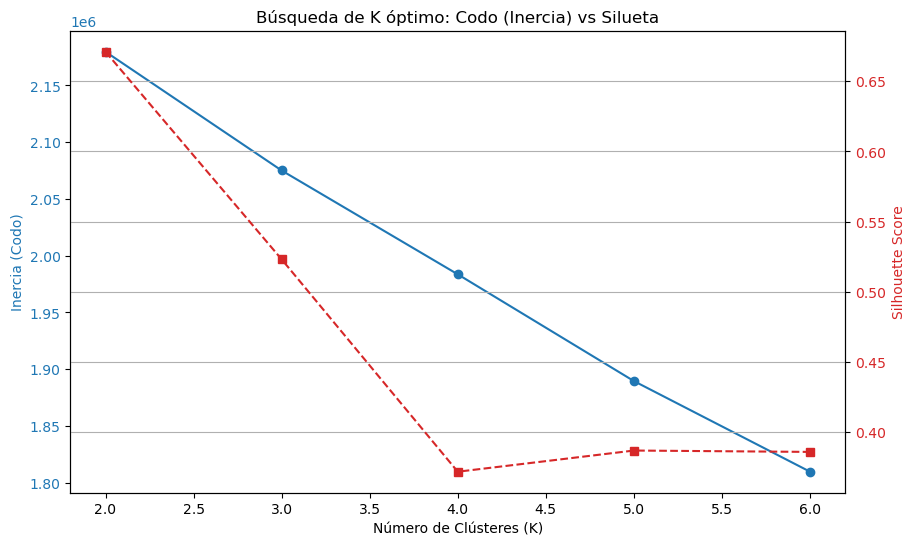

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

print("--- Iniciando Análisis para K-Means ---")
print("Buscando el K óptimo (esto puede tardar un poco por la Silueta)...")

inertia = []
silhouette_scores = []
K_range = range(2, 7)  # Probamos de 2 a 6 clústeres

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    # Calculamos silueta (usamos una muestra pequeña extra si tarda mucho, pero con 40k debería aguantar)
    # Nota: Si tu PC va lento, reduce el sample_size en silhouette_score
    score = silhouette_score(X_scaled, kmeans.labels_, sample_size=5000) 
    silhouette_scores.append(score)
    print(f"K={k}: Inertia={int(kmeans.inertia_)}, Silhouette={score:.4f}")

# Gráficos de Codo y Silueta
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Número de Clústeres (K)')
ax1.set_ylabel('Inercia (Codo)', color=color)
ax1.plot(K_range, inertia, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # Eje Y secundario
color = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(K_range, silhouette_scores, marker='s', linestyle='--', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Búsqueda de K óptimo: Codo (Inercia) vs Silueta')
plt.grid(True)
plt.show()

--- RESULTADOS K-MEANS  ---
Umbral de distancia aplicado: 9.80
Fraudes detectados: 61 de 74
Tasa de Detección (Recall): 82.43%
Falsos Positivos: 2075


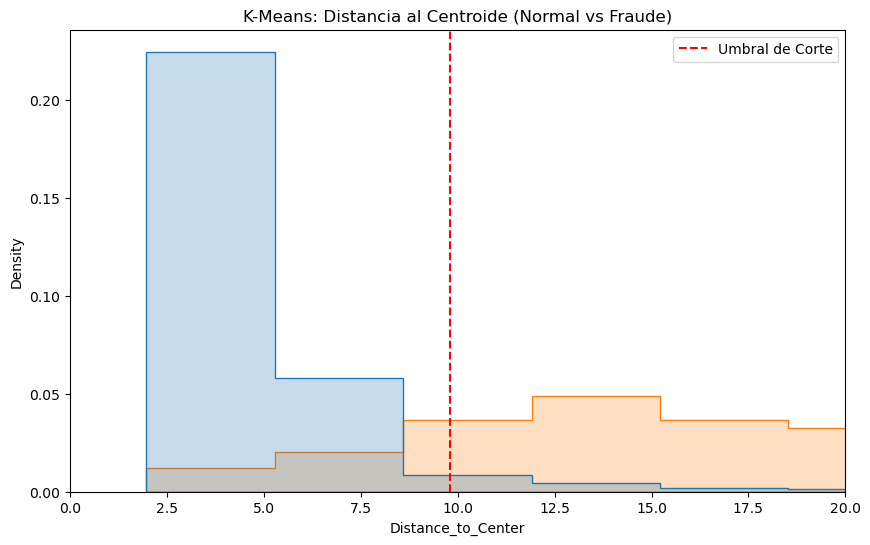

In [ ]:

from sklearn.cluster import KMeans

# Usamos K=5 para permitir que el modelo aprenda 5 tipos de comportamientos "normales" distintos
k_improved = 5 
kmeans_adv = KMeans(n_clusters=k_improved, random_state=42, n_init=10)
kmeans_adv.fit(X_scaled)

# 2. LA CLAVE: Calcular distancias al centroide
# transform() nos da la distancia de cada punto a TODOS los centros.
# min(axis=1) nos da la distancia a SU centro asignado.
distances = kmeans_adv.transform(X_scaled).min(axis=1)

df_sample['Distance_to_Center'] = distances

# 3. Definir el umbral (Threshold)
# Asumimos que el 5% de las transacciones más lejanas son sospechosas (regla de negocio)
threshold = np.percentile(distances, 95) 

# Etiquetamos: Si la distancia es mayor al umbral -> Es Anomalía (1)
df_sample['Pred_KMeans_Adv'] = (df_sample['Distance_to_Center'] > threshold).astype(int)

# 4. Evaluación
y_pred_km_adv = df_sample['Pred_KMeans_Adv']
tp_km = len(df_sample[(y_pred_km_adv == 1) & (df_sample['Class'] == 1)]) # Aciertos
fp_km = len(df_sample[(y_pred_km_adv == 1) & (df_sample['Class'] == 0)]) # Falsos positivos
recall_km = tp_km / df_sample['Class'].sum()

print(f"--- RESULTADOS K-MEANS  ---")
print(f"Umbral de distancia aplicado: {threshold:.2f}")
print(f"Fraudes detectados: {tp_km} de {df_sample['Class'].sum()}")
print(f"Tasa de Detección (Recall): {recall_km:.2%}")
print(f"Falsos Positivos: {fp_km}")

# 5. Gráfico para entender la mejora
plt.figure(figsize=(10, 6))
sns.histplot(data=df_sample, x='Distance_to_Center', hue='Class', bins=50, common_norm=False, stat="density", element="step")
plt.axvline(threshold, color='red', linestyle='--', label='Umbral de Corte')
plt.title('K-Means: Distancia al Centroide (Normal vs Fraude)')
plt.xlim(0, 20) # Limitamos eje X para ver mejor
plt.legend()
plt.show()